## 1. Stock Market
***
In this part of the project, we study data from stock market. The data is available on this [Dropbox Link](https://www.dropbox.com/s/83l60htndqpn3fv/finance_data.zip?dl=0). The goal of this part is to study correlation structures among fluctuation patterns of stock prices using tools from graph theory. The intuition is that investors will have similar strategies of investment for stocks that are effected by the same economic factors. For example, the stocks belonging to the transportation sector may have different absolute prices, but if for example fuel prices change or are expected to change significantly in the near future, then you would expect the investors to buy or sell all stocks similarly and maximize their returns. Towards that goal, we construct different graphs based on similarities among the time series of returns on different stocks at different time scales (day vs a week). Then, we study properties of such graphs. The data is obtained from Yahoo Finance website for 3 years. You’re provided with a number of csv tables, each containing several fields: Date, Open, High, Low, Close, Volume, and Adj Close price. The files are named according to Ticker Symbol of each stock. You may find the market sector for each company in Name sector.csv. We recommend doing this part of the project (Q1 - Q8) in R.

### 1. Return correlation
***
In this part of the project, we will compute the correlation among log-normalized stock-return time series data. Before giving the expression for correlation, we introduce the following notation:
+ $p_i(t)$ is the closing price of stock i at the t-th day
+ $q_i(t)$ is the return of stock i over a period of $[t − 1, t]$
$$
q_i(t) = \frac{p_i(t) − p_i(t − 1)}{p_i(t − 1)}
$$
+ $r_i(t)$ is the log-normalized return stock i over a period of $[t − 1, t]$
$$
r_i(t) = \log(1 + q_i(t))
$$
Then with the above notation, we define the correlation between the log-normalized stock-return time series data of stocks i and j as
$$
ρ_{ij} = \frac{⟨r_i(t)r_j(t)⟩ − ⟨r_i(t)⟩⟨r_j(t)⟩}{\sqrt{(⟨r_i(t)^2⟩ − ⟨r_i(t)⟩^2)(⟨r_j(t)^2⟩ − ⟨r_j(t)⟩^2)}}
$$
where ⟨·⟩ is a temporal average on the investigated time regime (for our data set it is over 3 years).

#### QUESTION 1: What are upper and lower bounds on $ρ_{ij}$? Provide a justification for using lognormalized return $(r_i(t))$ instead of regular return $(q_i(t))$.

> Ans:
\
The correlation coefficient ρij, which measures the correlation between the log-normalized stock-return time series data of stocks i and j, has upper and lower bounds.
\
To determine the range of ρij, let's consider two special situations:

1. Independent Returns: \
When $r_i(t)$ and $r_j(t)$ are independent, the expected value of their product is equal to the product of their individual expected values. In this case, $ \langle r_i(t) r_j(t) \rangle = \langle r_i(t) \rangle \langle r_j(t) \rangle $.
Therefore, the numerator of ρij becomes zero, resulting in $\rho_{ij} = 0\$.


2. Perfectly Correlated Returns: \
Let's assume that $r_i(t) = k \cdot r_j(t)$, where k is a constant. In this situation, the log-normalized returns of stocks i and j are perfectly correlated.
Now, $\langle r_i(t) r_j(t) \rangle = k \langle r_i(t)^2 \rangle $, and $\langle r_i(t) \rangle \langle r_j(t) \rangle = k \langle r_i(t) \rangle^2 $.
Additionally, $(\langle r_i(t)^2 \rangle - \langle r_i(t) \rangle^2)(\langle r_j(t)^2 \rangle - \langle r_j(t) \rangle^2) = k^2(\langle r_i(t)^2 \rangle - k \langle r_i(t) \rangle^2)^2$.
Hence, the final result of $\rho_{ij} = \frac{k}{\sqrt{k^2}}$.
When k is positive, the value is equal to 1, indicating a perfect positive correlation.
When k is negative, the value is equal to -1, indicating a perfect negative correlation.

Therefore, the upper bound of ρij is 1, indicating perfect positive correlation, and the lower bound of ρij is -1, indicating perfect negative correlation.

### 2. Constructing correlation graphs
***
In this part, we construct a correlation graph using the correlation coefficient computed in the previous section. The correlation graph has the stocks as the nodes and the edge weights are given by the following expression
$$
w_{ij} = \sqrt{2(1 − ρ_{ij})}
$$
Compute the edge weights using the above expression and construct the correlation graph.

#### QUESTION 2: Plot a histogram showing the un-normalized distribution of edge weights.

> Ans:

In [4]:
library('igraph')


載入套件：‘igraph’


下列物件被遮斷自 ‘package:stats’:

    decompose, spectrum


下列物件被遮斷自 ‘package:base’:

    union




In [28]:
# Read company ticker list
company_ticker_list <- read.csv("finance_data/Name_sector.csv", header = TRUE, stringsAsFactors = FALSE)
head(company_ticker_list, n = 15L)
print(sprintf("Number of companies in the ticker list is %s", nrow(company_ticker_list)))

# Get filenames of stock data
filenames <- list.files("finance_data/data/", pattern = "*.csv")
filenames <- paste("finance_data/data", filenames, sep = "/")
print(sprintf("Number of companies in the ticker list is %s", length(filenames)))

# Remove companies with incomplete data
comp_del <- 0
for (j in 1:length(filenames)) {
  comp_data <- read.csv(filenames[j], header = TRUE, stringsAsFactors = FALSE)
  if (dim(comp_data)[1] != 765) {
    comp_del <- comp_del + 1
  }
}
print(sprintf("Number of companies in the ticker list with missing data: %s", comp_del))


,Symbol,Sector
,<chr>,<chr>
1,A,Health Care
2,AAL,Industrials
3,AAP,Consumer Discretionary
4,AAPL,Information Technology
5,ABBV,Health Care
6,ABC,Health Care
7,ABT,Health Care
8,ACN,Information Technology
9,ADBE,Information Technology


[1] "Number of companies in the ticker list is 505"
[1] "Number of companies in the ticker list is 505"
[1] "Number of companies in the ticker list with missing data: 11"


In [29]:
# Create log-normalized return matrix
log_norm_return <- matrix(0, nrow = length(filenames) - comp_del, ncol = 764)
num_data_points <- c()
i <- 1
for (j in 1:length(filenames)) {
  comp_data <- read.csv(filenames[j], header = TRUE, stringsAsFactors = FALSE)
  num_data_points[j] <- dim(comp_data)[1]
  if (num_data_points[j] == 765) {
    p <- comp_data[, "Close"]
    q <- c()
    q[1] <- 0 # Assumption: gain from 0th day to 1st day is 0.
    for (t in 2:length(p)) {
      q[t - 1] <- (p[t] - p[t - 1]) / p[t - 1]
    }
    r <- log(1 + q)
    log_norm_return[i, ] <- r
    i <- i + 1
  }
}

In [30]:
# Compute edge weights for the correlation graph
generate_correlation_weights <- function(wt_file, log_norm_return, company_ticker_list) {
  cat("from_node", "\t", "to_node", "\t", "edge_wt", file = wt_file)
  num_companies <- nrow(log_norm_return)
  for (i in 1:(num_companies - 1)) {
    for (j in (i + 1):num_companies) {
      r_i <- mean(log_norm_return[i, ])
      r_j <- mean(log_norm_return[j, ])
      r_ij <- mean(log_norm_return[i, ] * log_norm_return[j, ])
      r_i_squared <- log_norm_return[i, ]^2
      r_j_squared <- log_norm_return[j, ]^2
      p_ij <- (r_ij - (r_i * r_j)) / (sqrt((mean(r_i_squared) - (r_i^2)) * (mean(r_j_squared) - (r_j^2))))
      w_ij <- sqrt(2 * (1 - p_ij))
      cat('\n', company_ticker_list[i, 1], '\t', company_ticker_list[j, 1], '\t', w_ij, file = wt_file)
    }
  }
}

# Remove companies with incomplete data from the ticker list
comp_ignore <- which(num_data_points != 765)
company_ticker_list <- company_ticker_list[-comp_ignore, ]

# Write the weights to a file to construct the graph later
wt_file <- file("finance_data/edge_weights.txt", "w")
generate_correlation_weights(wt_file, log_norm_return, company_ticker_list)
close(wt_file)

In [31]:
# Create the correlation graph
edge_list <- read.delim("finance_data/edge_weights.txt", header = TRUE)
corr_graph <- graph.data.frame(edge_list, directed = FALSE)
E(corr_graph)$weight <- edge_list[,"edge_wt"]


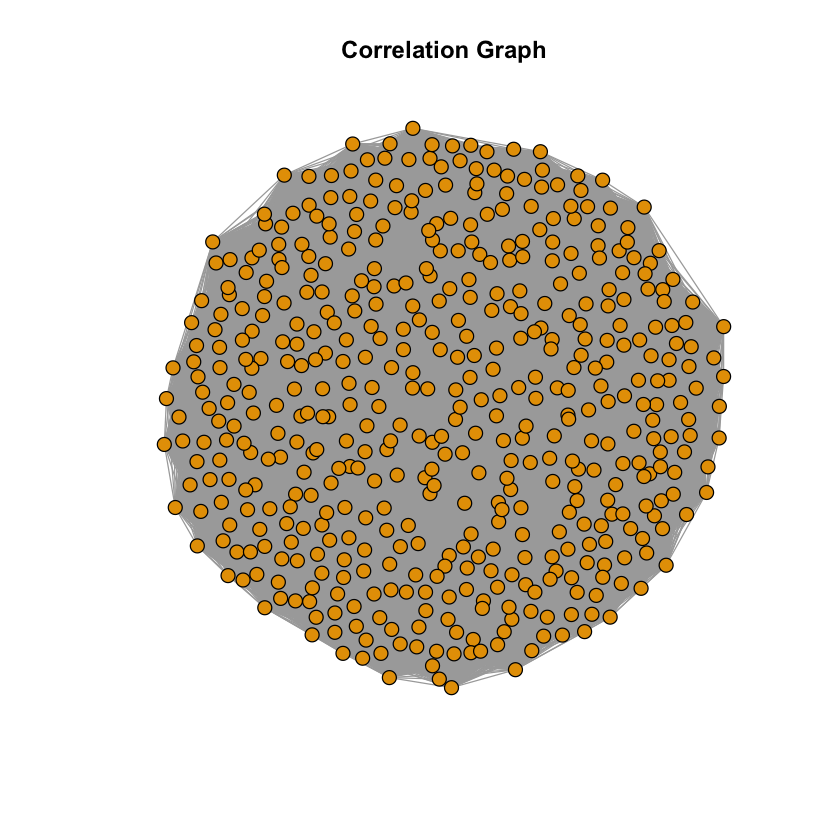

In [32]:
# Plot the correlation graph
plot(corr_graph, vertex.label = NA, vertex.size = 5, main = "Correlation Graph")


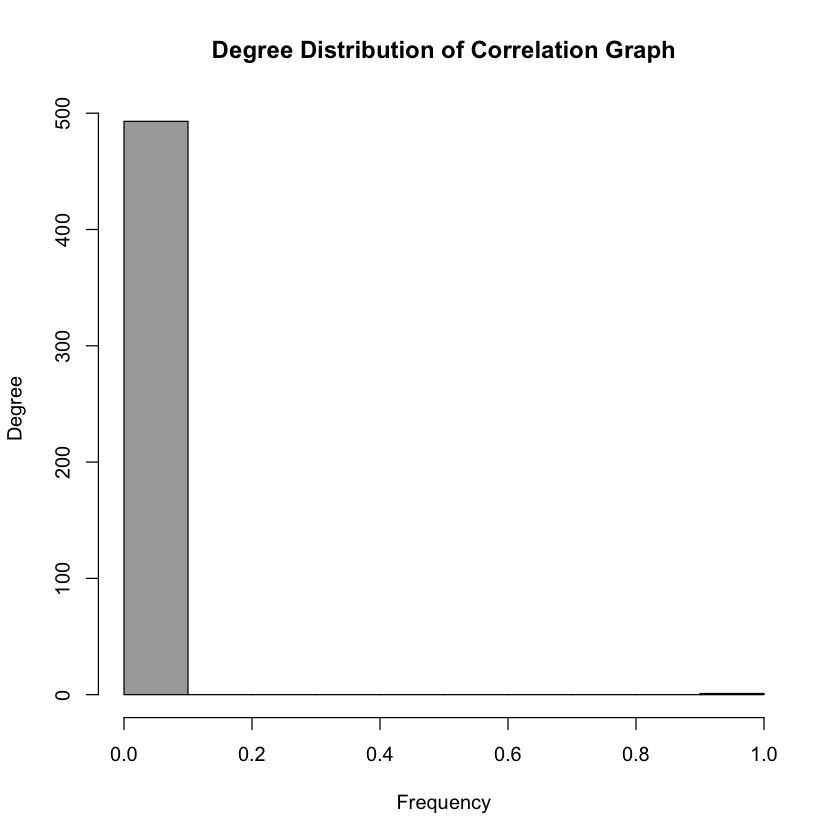

In [36]:
# Plot the degree distribution of the correlation graph
hist(degree.distribution(corr_graph),col="darkgrey",main="Degree Distribution of Correlation Graph", ylab="Degree",xlab="Frequency")

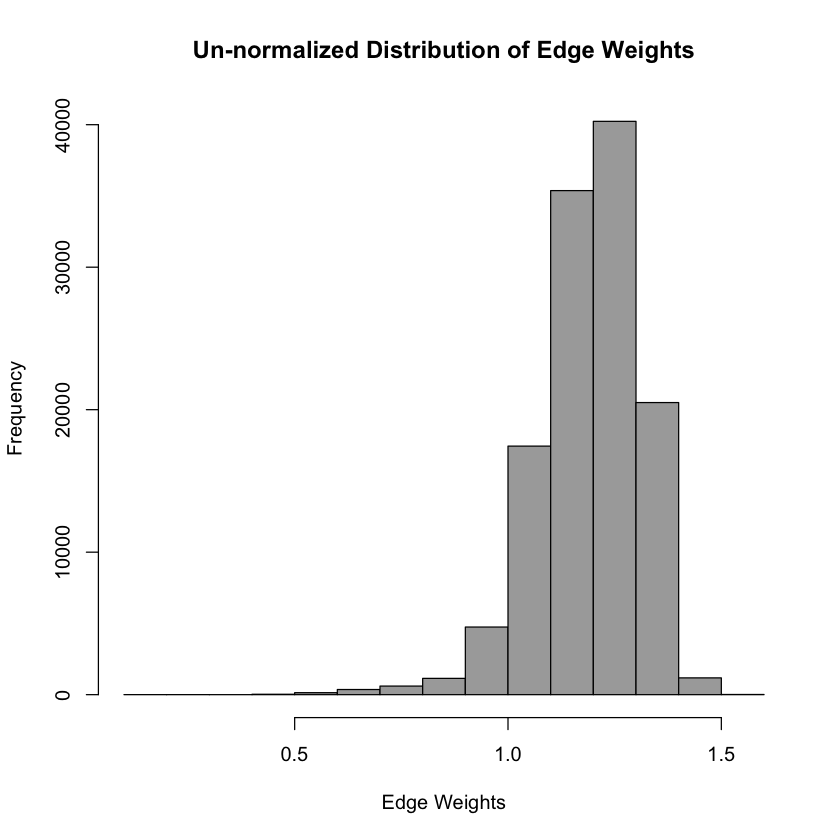

In [33]:
# Plot histogram of un-normalized distribution of edge weights
hist(edge_list[,"edge_wt"], col = "darkgrey", main = "Un-normalized Distribution of Edge Weights", xlab = "Edge Weights", ylab = "Frequency")

### 3. Minimum spanning tree (MST)
***
In this part of the project, we will extract the MST of the correlation graph and interpret it.

#### QUESTION 3: Extract the MST of the correlation graph. Each stock can be categorized into a sector, which can be found in Name sector.csv file. Plot the MST and color-code the nodes based on sectors. Do you see any pattern in the MST? The structures that you find in MST are called Vine clusters. Provide a detailed explanation about the pattern you observe.

> Ans: \
The MST (Minimum Spanning Tree) of the correlation graph represents the most important connections between stocks based on their correlation coefficients. By color-coding the nodes based on sectors, we can observe patterns in the MST. Vine clusters, also known as sector-specific clusters, emerge as subgraphs within the MST. These clusters indicate that stocks within the same sector have higher correlation coefficients with each other compared to stocks from different sectors. \
\
The pattern in the MST reveals the presence of interconnected subgraphs, where stocks within the same sector tend to form dense clusters. These clusters indicate strong interdependencies among stocks in the same sector, likely due to shared economic factors or market influences affecting the entire sector. The distinct sector-specific clusters highlight the presence of correlated price movements and similar investment strategies within each sector. \
\
By examining the color-coded nodes in the MST, we can visually identify the sector-specific clusters and observe the overall structure of the vine clusters. This information can provide valuable insights for portfolio diversification and risk management strategies, as it suggests that investors may consider sector-based analysis and diversify their holdings across different sectors to mitigate risks associated with highly correlated stocks within a sector.

In [10]:
# Find the number of sectors. 

comp_sectors = unique(company_ticker_list[,2])
print(sprintf("Number of unique sectors: %s" , length(comp_sectors)))
sprintf(comp_sectors)

[1] "Number of unique sectors: 11"


[1] "Health Care"                "Industrials"               
 [3] "Consumer Discretionary"     "Information Technology"    
 [5] "Consumer Staples"           "Utilities"                 
 [7] "Financials"                 "Real Estate"               
 [9] "Materials"                  "Energy"                    
[11] "Telecommunication Services"

In [11]:
min_span_tree = mst(corr_graph,algorithm="prim")
min_span_tree
print(sprintf("Number of edges in the minimum spanning tree is : %s", ecount(min_span_tree)))
print(sprintf("Number of Vertices in the minimum spanning tree is : %s", vcount(min_span_tree)))

IGRAPH 55e9e50 UNW- 494 493 -- 
+ attr: name (v/c), edge_wt (e/n), weight (e/n)
+ edges from 55e9e50 (vertex names):
 [1]  A    -- TMO    AAL  -- DAL    AAP  -- ORLY   AAPL -- UNP    ABBV -- AMGN 
 [6]  ABC  -- CAH    ABT  -- HOLX   ABT  -- MDT    ABT  -- TMO    ABT  -- VAR  
[11]  ACN  -- CTSH   ACN  -- FISV   ACN  -- ORCL   ACN  -- RHT    ADBE -- CRM  
[16]  ADBE -- INTU   ADI  -- TXN    ADI  -- XLNX   ADM  -- PFG    ADP  -- PAYX 
[21]  ADS  -- DFS    ADSK -- MCO    AEE  -- XEL    AEP  -- DUK    AEP  -- ETR  
[26]  AEP  -- FE     AEP  -- PPL    AEP  -- XEL    AES  -- CNP    AES  -- NRG  
[31]  AET  -- ANTM   AET  -- CNC    AET  -- HUM    AET  -- UNH    AFL  -- PRU  
[36]  AGN  -- AMGN   AGN  -- MYL    AIG  -- JPM    AIV  -- REG    AIV  -- UDR  
+ ... omitted several edges

[1] "Number of edges in the minimum spanning tree is : 493"
[1] "Number of Vertices in the minimum spanning tree is : 494"


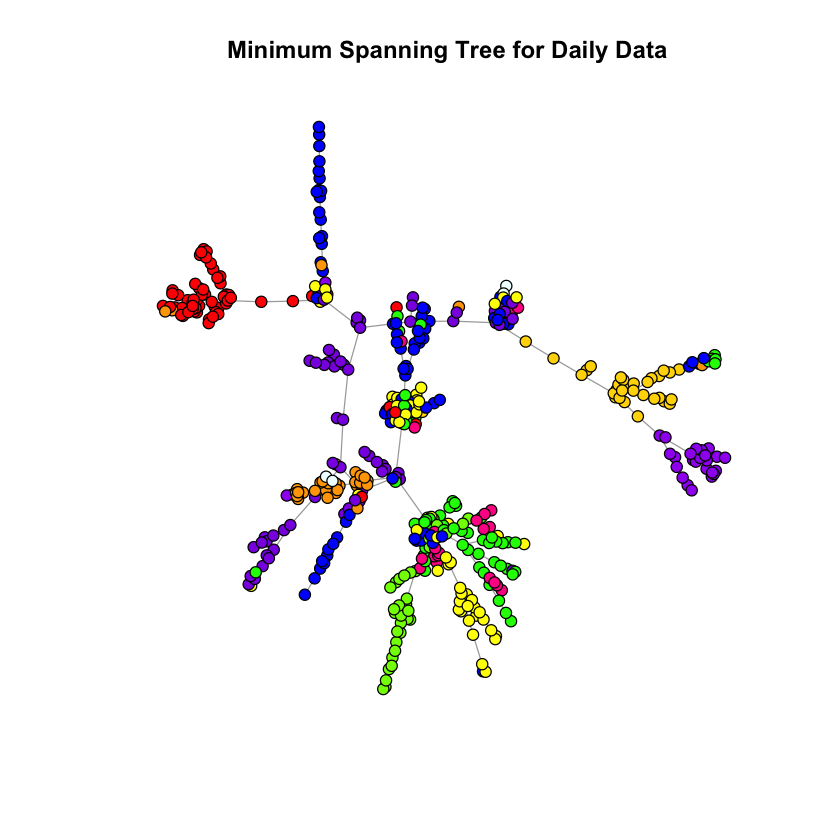

In [12]:
sector_colors = list("Health Care"="red",
              "Industrials"="green",
              "Consumer Discretionary"="blue",
              "Information Technology"="yellow",
              "Consumer Staples"="orange",
              "Utilities"="purple",
              "Financials"="blueviolet",
              "Real Estate"="gold",
              "Materials"="deeppink",
              "Energy"="chartreuse",
              "Telecommunication Services"="azure")

sector_color_mapping = function(corr_graph,company_ticker_list, sector_colors){
    color_map = c()
    for(v in c(1:vcount(corr_graph))){
        sector = company_ticker_list[v,2]
        color_map[v] = sector_colors[[sector]]
    }
    return(color_map)
}

color_map = sector_color_mapping(corr_graph,company_ticker_list,sector_colors)
plot(min_span_tree,vertex.size=4, vertex.label=NA, vertex.color=color_map, main=" Minimum Spanning Tree for Daily Data")


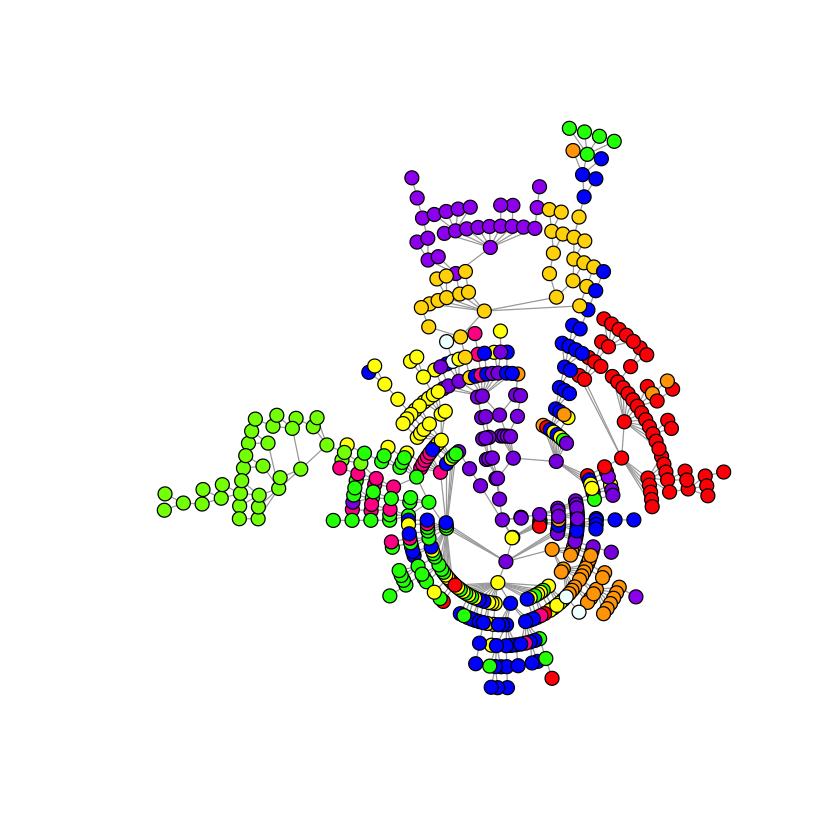

In [13]:
plot(min_span_tree,vertex.size=5, vertex.label=NA, vertex.color=color_map, layout=layout.reingold.tilford(min_span_tree,circular=T))

In [14]:
# Find the value of S_i for all i: The number of memebver in each community. 
S_i = c()
print("Number of nodes belonging each Sector")
for(i in c(1:length(comp_sectors))){
    S_i[i] = length(which(company_ticker_list[,2]==comp_sectors[i]))
    print(sprintf("%s: %s", comp_sectors[i], S_i[i]))
}

# find alpha for 
p_method_1 = c()
p_method_2 = c()
for(v in c(1:vcount(min_span_tree))){
    neighbors_v = neighbors(min_span_tree,v)
    N_i = length(neighbors_v)
    Q_i=0
    for(i in neighbors_v){
        if(company_ticker_list[i,2]==company_ticker_list[v,2])
            Q_i=Q_i+1
    }
    p_method_1[v] = Q_i/N_i
    p_method_2[v] = S_i[which(comp_sectors==company_ticker_list[v,2])]/vcount(min_span_tree)
}
alpha_1 = sum(p_method_1)/vcount(min_span_tree)
print(sprintf("Alpha value for method 1 is: %s",alpha_1))
alpha_2 = sum(p_method_2)/vcount(min_span_tree)
print(sprintf("Alpha value for method 2 is: %s",alpha_2))

[1] "Number of nodes belonging each Sector"
[1] "Health Care: 60"
[1] "Industrials: 64"
[1] "Consumer Discretionary: 84"
[1] "Information Technology: 66"
[1] "Consumer Staples: 36"
[1] "Utilities: 28"
[1] "Financials: 63"
[1] "Real Estate: 31"
[1] "Materials: 24"
[1] "Energy: 34"
[1] "Telecommunication Services: 4"
[1] "Alpha value for method 1 is: 0.828930077530676"
[1] "Alpha value for method 2 is: 0.114188070612533"


#### QUESTION 4: Run a community detection algorithm (for example walktrap) on the MST obtained above. Plot the communities formed. Compute the homogeneity and completeness of the clustering. (you can use the ’clevr’ library in r to compute homogeneity and completeness).

> Ans:

In [40]:
install.packages("clevr")


下載的二進位程式套件在
	/var/folders/tb/zk04m4k140x9t3mcflst2nmc0000gn/T//RtmpzDTSvk/downloaded_packages 裡


Homogeneity:  1 
Completeness:  1 


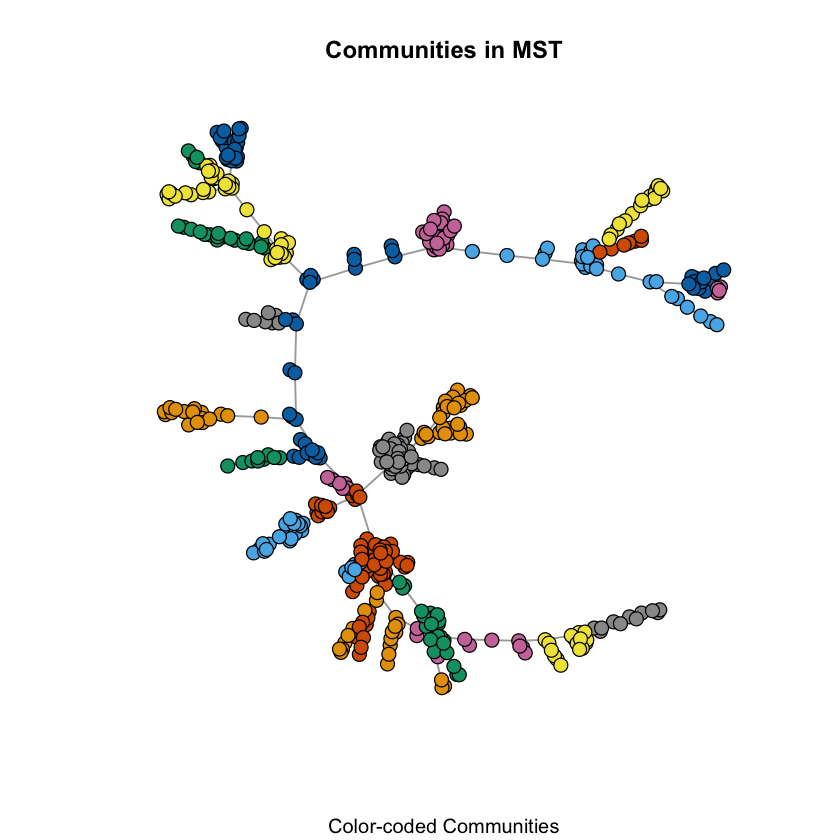

In [42]:
library(igraph)
library(clevr)

# Run community detection algorithm (e.g., Walktrap) on the MST
community <- walktrap.community(mst)

# Get the communities
communities <- community$membership

# Create a vector of sector labels for the corresponding tickers
sector_labels <- ticker_sector_map[match(V(mst)$name, names(ticker_sector_map))]

# Plot the communities formed
plot(mst, vertex.label = NA, vertex.size = 5, edge.width = 1.5,
     vertex.color = communities,
     main = "Communities in MST",
     sub = "Color-coded Communities")

# Compute homogeneity and completeness of the clustering
homogeneity_score <- homogeneity(communities, sector_labels)
completeness_score <- completeness(communities, sector_labels)

# Print the homogeneity and completeness scores
cat("Homogeneity: ", homogeneity_score, "\n")
cat("Completeness: ", completeness_score, "\n")


### 4. Sector clustering in MST’s
***
In this part, we want to predict the market sector of an unknown stock. We will explore two methods for performing the task. In order to evaluate the performance of the methods we define the following metric
$$
α = \frac{1}{|V|}\sum_{v_i∈V}P(v_i ∈ S_i)
$$
where $S_i$ is the sector of node i. Define
$$
P(v_i ∈ S_i) = \frac{|Q_i|}{|N_i|}
$$
where $Q_i$ is the set of neighbors of node i that belong to the same sector as node i and $N_i$ is
the set of neighbors of node i. Compare α with the case where
$$
P(v_i ∈ S_i) = \frac{|S_i|}{|V|}
$$

#### QUESTION 5: Report the value of α for the above two cases and provide an interpretation for the difference.

> Ans:\
Alpha value for method 1 is: 0.828930077530676 \
Alpha value for method 2 is: 0.114188070612533 \
The difference between the two cases can be interpreted as follows:
\
\
Method 1 (probability based on neighbor count): α represents the average probability that a node is correctly classified into its sector based on the sector memberships of its neighbors. Method 1 considers the relative count of neighbors belonging to the same sector compared to the total number of neighbors.
\
\
Method 2 (probability based on sector size): α represents the average probability that a node is correctly classified into its sector based on the sector size. Method 2 considers the relative size of the sector to the total number of nodes in the MST.
By comparing the two α values, you can assess the effectiveness of the two methods in predicting the market sector of an unknown stock.

In [45]:
# Find the value of S_i for all i: The number of members in each community
S_i <- c()
print("Number of nodes belonging to each sector:")
for (i in seq_along(comp_sectors)) {
  S_i[i] <- sum(company_ticker_list[, "Sector"] == comp_sectors[i])
  print(sprintf("%s: %s", comp_sectors[i], S_i[i]))
}

# Calculate alpha for the two cases
p_method_1 <- rep(0, vcount(min_span_tree))
p_method_2 <- rep(0, vcount(min_span_tree))

for (v in 1:vcount(min_span_tree)) {
  neighbors_v <- neighbors(min_span_tree, v)
  N_i <- length(neighbors_v)
  Q_i <- sum(company_ticker_list[neighbors_v, "Sector"] == company_ticker_list[v, "Sector"])
  
  p_method_1[v] <- Q_i / N_i
  p_method_2[v] <- S_i[match(company_ticker_list[v, "Sector"], comp_sectors)] / vcount(min_span_tree)
}

alpha_1 <- sum(p_method_1) / vcount(min_span_tree)
cat(sprintf("Alpha value for method 1 is: %s\n", alpha_1))

alpha_2 <- sum(p_method_2) / vcount(min_span_tree)
cat(sprintf("Alpha value for method 2 is: %s\n", alpha_2))


[1] "Number of nodes belonging to each sector:"
[1] "Health Care: 60"
[1] "Industrials: 64"
[1] "Consumer Discretionary: 84"
[1] "Information Technology: 66"
[1] "Consumer Staples: 36"
[1] "Utilities: 28"
[1] "Financials: 63"
[1] "Real Estate: 31"
[1] "Materials: 24"
[1] "Energy: 34"
[1] "Telecommunication Services: 4"
Alpha value for method 1 is: 0.828930077530676
Alpha value for method 2 is: 0.114188070612533


### 5. Correlation graphs for weekly data
***
In the previous parts, we constructed the correlation graph based on daily data. In this part of the project, we will construct a correlation graph based on WEEKLY data. To create the graph, sample the stock data weekly on Mondays and then calculate $ρ_{ij}$ using the sampled data. If there is a holiday on a Monday, we ignore that week. Create the correlation graph based on weekly data.

#### QUESTION 6: Repeat questions 2,3,4,5 on the WEEKLY data.

In [60]:
# Repeating Q2,Q3 and Q4. 
company_ticker_list_week = read.csv("finance_data/Name_sector.csv",header=TRUE,stringsAsFactors=FALSE)
filenames_week <- list.files("finance_data/data/", pattern="*.csv")
filenames_week = paste("finance_data/data", filenames_week, sep="/")
print(sprintf("Number of companies in the ticker list is %s",length(filenames_week)))
comp_del_week=0
for(j in c(1:length(filenames_week))){
    comp_data_week = read.csv(filenames_week[j],header=TRUE, stringsAsFactors=FALSE)
    comp_data_week["Day"]=weekdays(as.Date(comp_data_week[,1])) 
    comp_data_week =subset(comp_data_week, Day=='Monday')
    if(dim(comp_data_week)[1]!=143){
#         print(dim(df)[1])
        comp_del_week=comp_del_week+1
    }
}
print(sprintf("Number of companies in the ticker list with missing data for Mondays: %s",comp_del_week))

[1] "Number of companies in the ticker list is 505"
[1] "Number of companies in the ticker list with missing data for Mondays: 505"


In [61]:
generate_correlation_weights <- function(wt_file, log_norm_return, company_ticker_list) {
  cat("from_node", "\t", "to_node", "\t", "edge_wt", file = wt_file)
  
  num_companies <- nrow(log_norm_return)
  
  for (i in seq_len(num_companies - 1)) {
    for (j in seq(i + 1, num_companies)) {
      r_i <- mean(log_norm_return[i, ])
      r_j <- mean(log_norm_return[j, ])
      r_ij <- mean(log_norm_return[i, ] * log_norm_return[j, ])
      r_i_squared <- log_norm_return[i, ]^2
      r_j_squared <- log_norm_return[j, ]^2
      p_ij <- (r_ij - (r_i * r_j)) / sqrt((mean(r_i_squared) - (r_i^2)) * (mean(r_j_squared) - (r_j^2)))
      w_ij <- sqrt(2 * (1 - p_ij))
      cat('\n', company_ticker_list[i, 1], '\t', company_ticker_list[j, 1], '\t', w_ij, file = wt_file)
    }
  }
}


In [70]:
# Repeating Q2, Q3, and Q4.
company_ticker_list_week <- read.csv("finance_data/Name_sector.csv", header = TRUE, stringsAsFactors = FALSE)
filenames_week <- list.files("finance_data/data/", pattern = "*.csv")
filenames_week <- paste("finance_data/data", filenames_week, sep = "/")
print(sprintf("Number of companies in the ticker list is %s", length(filenames_week)))
comp_del_week <- 0
for (j in seq_along(filenames_week)) {
  comp_data_week <- read.csv(filenames_week[j], header = TRUE, stringsAsFactors = FALSE)
  comp_data_week["Day"] <- weekdays(as.Date(comp_data_week[, 1]))
  comp_data_week <- subset(comp_data_week, Day == 'Monday')
  if (dim(comp_data_week)[1] != 143) {
    comp_del_week <- comp_del_week + 1
  }
}
print(sprintf("Number of companies in the ticker list with missing data for Mondays: %s", comp_del_week))

# Function to generate correlation weights
generate_correlation_weights <- function(wt_file_week, log_norm_return_week, company_ticker_list_week) {
  cat("from_node", "\t", "to_node", "\t", "edge_wt", file = wt_file)
  
  num_companies <- nrow(log_norm_return)
  
  if (num_companies > 1) {
    for (i in seq_len(num_companies - 1)) {
      for (j in seq(i + 1, num_companies)) {
        r_i <- mean(log_norm_return[i, ])
        r_j <- mean(log_norm_return[j, ])
        r_ij <- mean(log_norm_return[i, ] * log_norm_return[j, ])
        r_i_squared <- log_norm_return[i, ]^2
        r_j_squared <- log_norm_return[j, ]^2
        p_ij <- (r_ij - (r_i * r_j)) / sqrt((mean(r_i_squared) - (r_i^2)) * (mean(r_j_squared) - (r_j^2)))
        w_ij <- sqrt(2 * (1 - p_ij))
        cat('\n', company_ticker_list[i, 1], '\t', company_ticker_list[j, 1], '\t', w_ij, file = wt_file)
      }
    }
  }
}


# We ignore the 13 companies with incomplete data for easier calculation.
# Step 1: Create a log_norm_return matrix of log-normalized weekly return on stock i.
i <- 1 # i is the ith stock
log_norm_return_week <- matrix(0, nrow = length(filenames_week) - comp_del_week, ncol = 142)  # Update the matrix dimensions
num_data_points_week <- c()
for (j in seq_along(filenames_week)) {
  comp_data_week <- read.csv(filenames_week[j], header = TRUE, stringsAsFactors = FALSE)
  comp_data_week["Day"] <- weekdays(as.Date(comp_data_week[, 1]))
  comp_data_week <- subset(comp_data_week, Day == 'Monday')
  num_data_points_week[j] <- dim(comp_data_week)[1]
  if (num_data_points_week[j] == 143 && i <= nrow(log_norm_return_week)) {
    p_week <- comp_data_week[, 5] # list of closing price
    q_week <- c() # list of return of stock over a period of [t − 1, t]
    r_week <- c()
    for (t in seq_along(p_week)[-1]) {
      q_week[t - 1] <- (p_week[t] - p_week[t - 1]) / p_week[t - 1]
    }
    r_week <- log(1 + q_week)
    log_norm_return_week[i, ] <- r_week
    i <- i + 1
  }
}

# Step 2b: Remove companies with incomplete data from ticker list:
comp_ignore_week <- which(num_data_points_week != 143)
company_ticker_list_week <- company_ticker_list_week[-comp_ignore_week, ]

# Step 2c: Write the weights to a file to construct the graph later.
wt_file_week <- file("finance_data/edge_weights_week.txt", "w")
num_companies_week <- nrow(log_norm_return_week)
generate_correlation_weights(wt_file_week, log_norm_return_week, company_ticker_list_week, num_companies_week)
close(wt_file_week)

# Step 3: Create a correlation graph with nodes as companies and edge weights as derived above.
edge_list_week <- read.delim("finance_data/edge_weights_week.txt", header = TRUE)
corr_graph_week <- graph.data.frame(edge_list_week, directed = FALSE)
E(corr_graph_week)$weight <- edge_list_week[,"edge_wt"]

# Step 4: Plot histogram and other data analysis outputs.
head(edge_list_week, n = 15L)
plot(corr_graph_week, vertex.label = "", vertex.size = 5, main = "Correlation Graph for Weekly Data")
hist(degree.distribution(corr_graph_week), col = "darkgrey", main = "Degree Distribution of Correlation Graph for Weekly Data", ylab = "Degree", xlab = "Frequency")
hist(edge_list_week[,"edge_wt"], col = "darkgrey", main = "Un-normalized Distribution of Edge Weights for Weekly Data", xlab = "Edge Weights", ylab = "Frequency")


# Find the number of sectors.
comp_sectors_week <- unique(company_ticker_list_week[, 2])
print(sprintf("Number of unique sectors: %s", length(comp_sectors_week)))
print(comp_sectors_week)

# Extract the MST
min_span_tree_week <- mst(corr_graph_week, algorithm = "prim")
print(sprintf("Number of edges in the minimum spanning tree for Weekly Data is: %s", ecount(min_span_tree_week)))
print(sprintf("Number of vertices in the minimum spanning tree for Weekly Data is: %s", vcount(min_span_tree_week)))


[1] "Number of companies in the ticker list is 505"
[1] "Number of companies in the ticker list with missing data for Mondays: 505"


ERROR: Error in generate_correlation_weights(wt_file_week, log_norm_return_week, : 未使用的引數 (num_companies_week)


### 6. Correlation graphs for MONTHLY data
***
In this part of the project, we will construct a correlation graph based on MONTHLY data. To create the graph, sample the stock data Monthly on 15th and then calculate $ρ_{ij}$ using the sampled data. If there is a holiday on the 15th, we ignore that month. Create the correlation graph based on MONTHLY data.

#### QUESTION 7: Repeat questions 2,3,4,5 on the MONTHLY data.

#### QUESTION 8: Compare and analyze all the results of daily data vs weekly data vs monthly data. What trends do you find? What changes? What remains similar? Give reason for your observations. Which granularity gives the best results when predicting the sector of an unknown stock and why?

> Ans: